<link rel='stylesheet' href='../assets/css/main.css'/>

[<< back to main index](../README.md)

# Linear Regression in PySpark (Demo)

### Overview
Instructor to demo this on screen.
 
### Builds on
None

### Run time
approx. 20-30 minutes

### Notes

PySpark has a class called Linear Regression that can be used to do simple linear regression models.

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print('Spark UI running on http://18.208.221.237:' + sc.uiWebUrl.split(':')[2])

Spark UI running on http://18.208.221.237:4040


## Example : Tips
Here is our tip data.  This shows 10 observations of bill with tip amounts.

| bill | tip | 
|------|-----| 
| 50   | 12  | 
| 30   | 7   | 
| 60   | 13  | 
| 40   | 8   | 
| 65   | 15  | 
| 20   | 5   | 
| 10   | 2   | 
| 15   | 2   | 
| 25   | 3   | 
| 35   | 4   | 

## Step 1: Let's create a Pandas dataframe with the data

Note that pandas dataframes are not the same as spark dataframes.  However, Pandas dataframes are ubiquitous in python (for small datasets) and are a nifty way to ensure that we have our data's schema match perfectly.

In [6]:
tip_data = pd.DataFrame({'bill' : [50.00, 30.00, 60.00, 40.00, 65.00, 20.00, 10.00, 15.00, 25.00, 35.00],
              'tip' : [12.00, 7.00, 13.00, 8.00, 15.00, 5.00, 2.00, 2.00, 3.00, 4.00]
             })

tip_data


,bill,tip
0,50.0,12.0
1,30.0,7.0
2,60.0,13.0
3,40.0,8.0
4,65.0,15.0
5,20.0,5.0
6,10.0,2.0
7,15.0,2.0
8,25.0,3.0
9,35.0,4.0


## Step 2: Let's do a quick plot of the data
Let us use matplotlib to do a quick scatter plot of the data. Note that this is not a Spark dataframe, this is using the pandas dataframe.

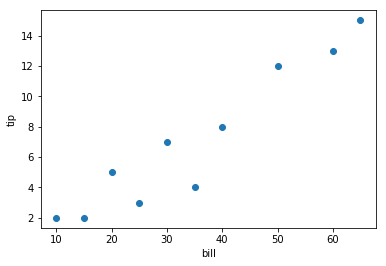

In [3]:
plt.scatter(tip_data.bill, tip_data.tip)
plt.ylabel('tip')
plt.xlabel('bill')
plt.show()

## Step 3: Create a Spark Dataframe
Let's now take our pandas dataframe and make a spark dataframe out of it.

In [4]:
spark_tips = spark.createDataFrame(tip_data)
spark_tips.show(100)

+----+----+
|bill| tip|
+----+----+
|50.0|12.0|
|30.0| 7.0|
|60.0|13.0|
|40.0| 8.0|
|65.0|15.0|
|20.0| 5.0|
|10.0| 2.0|
|15.0| 2.0|
|25.0| 3.0|
|35.0| 4.0|
+----+----+



## Step 4: Create a Features column with the Vector

We need to create a feature vector here.  You might wonder why we need a "vector" after all there's only one variable: "bill."  Nonetheless, we still need the dataframe to have a column called "features" of type Vector Double).

Luckily, there's a handy class called VectorAssembler that does this for us.

In [17]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["bill"], outputCol="features")
featureVector = assembler.transform(spark_tips)

featureVector.show()


+----+----+--------+
|bill| tip|features|
+----+----+--------+
|50.0|12.0|  [50.0]|
|30.0| 7.0|  [30.0]|
|60.0|13.0|  [60.0]|
|40.0| 8.0|  [40.0]|
|65.0|15.0|  [65.0]|
|20.0| 5.0|  [20.0]|
|10.0| 2.0|  [10.0]|
|15.0| 2.0|  [15.0]|
|25.0| 3.0|  [25.0]|
|35.0| 4.0|  [35.0]|
+----+----+--------+



## Step 5: Create a Label column with the Vector

We need a way to have the outcome variable.  In this case, we are trying to predict the tip from the bill.  So, we need to signal to Spark MLlib which one is the outcome variable.  In this case, we'll create a new variable called label.

In [18]:
## TODO : create a new column to mirror 'tip'
featureVector = featureVector.withColumn("label", featureVector["tip"])

# featureVector = featureVector.withColumnRenamed("tip", "label")  # this will rename existing tip column

featureVector.show()

+----+----+--------+-----+
|bill| tip|features|label|
+----+----+--------+-----+
|50.0|12.0|  [50.0]| 12.0|
|30.0| 7.0|  [30.0]|  7.0|
|60.0|13.0|  [60.0]| 13.0|
|40.0| 8.0|  [40.0]|  8.0|
|65.0|15.0|  [65.0]| 15.0|
|20.0| 5.0|  [20.0]|  5.0|
|10.0| 2.0|  [10.0]|  2.0|
|15.0| 2.0|  [15.0]|  2.0|
|25.0| 3.0|  [25.0]|  3.0|
|35.0| 4.0|  [35.0]|  4.0|
+----+----+--------+-----+




## Step 6: Run Linear Regression in Spark

Let's run our linear regression.  To do this we need to run call the LinearRegression Classs

In [19]:
from pyspark.ml.regression import LinearRegression

## TODO: set number of iterations to 10
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

## TODO : Try with default params too
# lr = LinearRegression(maxIter=10)  # default params -- zero

lrModel = lr.fit(featureVector)

intercept = lrModel.intercept  # This is the intercept
slope = lrModel.coefficients[0] #This is the slope

print("linear model : ", lrModel)
print("intercept : ", intercept)
print("slope : ", slope)

linear model :  LinearRegression_4e78836e8d00f520d727
intercept :  -0.8217112049846651
slope :  0.2263346058567047


## Step 7: Plot the fit line (abline)

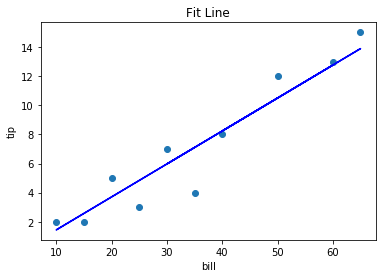

In [20]:
# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in tip_data.bill]

# Plot the best fit line over the actual values
plt.scatter(tip_data.bill, tip_data.tip)
plt.plot(tip_data.bill, abline_values, 'b')
plt.ylabel('tip')
plt.xlabel('bill')
plt.title("Fit Line")
plt.show()

## Step 8: Print out model metrics

In [21]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients[0]))
print("Intercept: %s" % str(lrModel.intercept))


# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

Coefficients: 0.2263346058567047
Intercept: -0.8217112049846651
numIterations: 3
objectiveHistory: [0.5000000000000002, 0.4158224893708402, 0.10101250448579287]
RMSE: 1.413302


In [22]:
## Other metrics
#trainingSummary.residuals.show()

### Correlation Coefficient (r)
Correlation Coefficient (r) denotes how strongly X & Y are inter-related.  

Spark ML can create a correlation Matrix which shows how all the variables in the dataset are correlated, if at all.  Naturally, every variable will have a correlation of 1 when compared to itself.


In [23]:
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=["bill", "tip"], outputCol="features")
correlationVector = assembler.transform(spark_tips)

r1 = Correlation.corr(correlationVector, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))


Pearson correlation matrix:
DenseMatrix([[1.        , 0.95221535],
             [0.95221535, 1.        ]])


**==>  Question : Does bill amount influence tip amount? (are they strongly linked?)**


## Coefficient of Determination (r&sup2;)

In [25]:
## TODO : print 'r2' from training summary
## Hint : Use TAB completion
print("r2: %f" % trainingSummary.r2)

r2: 0.902517


## Step 9: Plot the residuals

Residuals are the error, or difference between the model predicted and model actual.  We'd like these to be as small as possible, with residuals roughly balanced.   We don't want a model that consistently predicts values too high or too low.

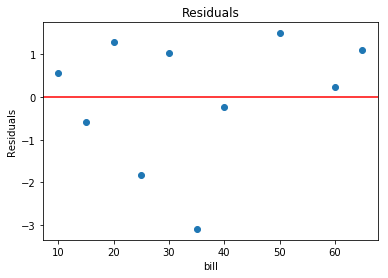

In [27]:
# TODO: do a plot of the bill (x-value) versus residuals (y-value)

residuals = lrModel.summary.residuals.toPandas()
plt.scatter(tip_data.bill, residuals['residuals'])
plt.axhline(y=0, color='r', linestyle='-')  # horizon
plt.ylabel('Residuals')
plt.xlabel('bill')
plt.title("Residuals")
plt.show()

## Step 10: Calculate tip for $100 bill

In [ ]:
# Print the coefficients and intercept for linear regression
print("Slope: %s" % str(lrModel.coefficients[0]))
print("Intercept: %s" % str(lrModel.intercept))

a = lrModel.coefficients[0]
b = lrModel.intercept

In [ ]:

bill = ???
## we have already calculated a & b above
tip_for_100 = a * bill + b
print("tip for $100 bill = ", tip_for_100)


## Step 11: Add a estimated_tip column to pandas and spark dataframe


In [ ]:
tip_data['est_tip'] =  tip_data.bill * a + b

tip_data

### Add estimated tip column to pyspark dataframe

This is a bit tricky. We need to use the sql expr function to make this work.

The formula: (bill * a) + b

In [ ]:
from pyspark.sql.functions import expr

formula = "(bill * " + str(a) + ") + " + str(b)

print(formula)
## Step 6: Add estimated tip column to spark dataframe
spark_tips_with_est = spark_tips.withColumn("est_tip", expr(formula))
spark_tips_with_est.show()

## Step 12: Perform a prediction
Let's try to run a prediction on some data: $45.00, $55.00, and $65.00 


In [ ]:
test_data_pd = pd.DataFrame({'bill' : [45., 55., 65.],
             })
test_data_spark =  spark.createDataFrame(test_data_pd)
test_assembler = VectorAssembler(inputCols=["bill"], outputCol="features")
test_features = test_assembler.transform(test_data_spark)

## Hint : Transform 'test_features'
test_predictions = lrModel.transform(???)

test_predictions.show()

## Step 13: Complete Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import expr


# tip = a * amount + b

# Make a Pandas dataframe
tip_data = pd.DataFrame({'bill' : [50.00, 30.00, 60.00, 40.00, 65.00, 20.00, 10.00, 15.00, 25.00, 35.00],
              'tip' : [12.00, 7.00, 13.00, 8.00, 15.00, 5.00, 2.00, 2.00, 3.00, 4.00]
             })
                       
print(tip_data)

#Plot the Tip Data
plt.scatter(tip_data.bill, tip_data.tip)
plt.ylabel('tip')
plt.xlabel('bill')
plt.show()


# Create a Spark Dataframe
spark_tips = spark.createDataFrame(tip_data)
spark_tips.show()

# Create a Features Columns
assembler = VectorAssembler(inputCols=["bill"], outputCol="features")
featureVector = assembler.transform(spark_tips)

featureVector.show()

# Create the label column
featureVector = featureVector.withColumn("label", featureVector["tip"])
featureVector.show()

# Run Linear Regression
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(featureVector)


intercept = lrModel.intercept  # This is the intercept
slope = lrModel.coefficients[0] #This is the slope

# Plot the best fit line over the actual values
abline_values = [slope * i + intercept for i in tip_data.bill]
plt.scatter(tip_data.bill, tip_data.tip)
plt.plot(tip_data.bill, abline_values, 'b')
plt.ylabel('tip')
plt.xlabel('bill')
plt.title("Fit Line")
plt.show()

# Summarize the model over the training set and print out some metrics
print("Coefficients: %s" % str(lrModel.coefficients[0]))
print("Intercept: %s" % str(lrModel.intercept))
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

#Plot Residuals
residuals = lrModel.summary.residuals.toPandas()
plt.scatter(tip_data.bill, residuals['residuals'])
plt.axhline(y=0, color='r', linestyle='-')  # horizon
plt.ylabel('Residuals')
plt.xlabel('bill')
plt.title("Residuals")
plt.show()



# Calculate Tip for $100 bill
tip_for_100 = a * 100 + b   
print(tip_for_100)


# Add est_tip to dataframes
tip_data['est_tip'] = tip_data.bill * a + b  #Pandas
tip_data

formula = "(bill * " + str(a) + ") + " + str(b)  #Spark
spark_tips_with_est = spark_tips.withColumn("est_tip", expr(formula))
spark_tips_with_est.show()